# Exercise multimodal recognition: RGB-D scene recognition

This exercise consists of three parts: two tutorials and the deliverable. The students must modify the code of the tutorial part, and write and discuss the results in the deliverable part that will be used to evaluate the exercise.

If you are not familiar with jupyter notebooks please check __[this tutorial](https://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/What%20is%20the%20Jupyter%20Notebook.html)__ first.

# Part 1 (tutorial): RGB baseline

In this tutorial, you will use a pretrained convolutional network and replace the classifier for the target dataset using PyTorch. The code is loosely based on the __[PyTorch transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)__. Just execute the code sequentially, paying attention to the comments.

In [1]:
import torch
import torch.nn as nn
import sys
from tqdm import tqdm
from torch import optim
from torch import cuda
from torch.utils import data
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools

from utils import imshow_unimodal, MEAN_RGB, STD_RGB

plt.ion()  # interactive mode


Load Data
---------

We will use torchvision, torch.utils.data and RGBDutils packages for loading the
data. The dataset is structured hierarchically in splits\modalities\classes (check the folder).

In [10]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_RGB, STD_RGB)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_RGB, STD_RGB)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_RGB, STD_RGB)
    ]),
}

# Modalities
modality = 'rgb'

# Path to the dataset
data_dir = '../datasets/sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x, modality),
                                          data_transforms[x])
                  for x in partitions}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=4,
                                  shuffle=True, num_workers=4)
               for x in partitions}
dataset_sizes = {x: len(image_datasets[x]) for x in partitions}
class_names = image_datasets['train'].classes

use_gpu = cuda.is_available()


In [11]:
image_datasets


{'train': Dataset ImageFolder
     Number of datapoints: 745
     Root Location: ../datasets/sunrgbd_lite/train/rgb
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                          )
     Target Transforms (if any): None, 'val': Dataset ImageFolder
     Number of datapoints: 868
     Root Location: ../datasets/sunrgbd_lite/val/rgb
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                          )

**Visualize a few images**

Let's visualize a few images to get familiar with the dataset.

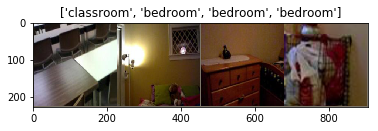

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs, classes = inputs[0:4], classes[0:4]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_unimodal(out, title=[class_names[x] for x in classes])


Training the model
------------------

Now, let's write a general function to train a model. Details:

-  Uses Adam algorithm for gradient descent.
-  Early stoping using best validation accuracy

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs), file=sys.stdout, desc="Training"):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('Phase %s' % phase)
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                # running_loss += loss.data[0] * inputs.size(0)
                # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
                running_loss += loss.data.item() * inputs.size(0)  # Pytorch 1.0
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.floats() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [14]:
def evaluate_model(model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs.size(0)  # Pytorch 1.0
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[partition]
    test_acc = running_corrects.floats() / dataset_sizes[partition]

    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss


And now, a function to evaluate the model on a particular set.

The network
----------------------

The architecture of the network is shown in the following figure:
<img src="figures/rgb_network.png" />

The following code creates the RGB network by (downloading and) instantiating an AlexNet trained on ImageNet.

In [15]:
# Instantiate the model
model = models.alexnet(pretrained=True)

# You can visualize the network
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

Set up the training/fine tuning parameters
----------------------

The following code creates the optimization criterio and set per-layer training rates to better control the fine tuning and training process. We use a very simple model in which all layers are frozen except the last fully connected one, i.e. the classifier, so it should be easy to improve the performance.

In [16]:
for param in model.parameters():
    param.requires_grad = False

num_classes = len(class_names)
c = model.classifier
num_ftrs = c[6].in_features
model.classifier = nn.Sequential(c[0], c[1], c[2], c[3], c[4], c[5], nn.Linear(num_ftrs, num_classes))

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
perlayer_optim = [
    {'params': model.features[0].parameters(), 'lr': 0.00},  # conv1
    {'params': model.features[3].parameters(), 'lr': 0.00},  # conv2
    {'params': model.features[6].parameters(), 'lr': 0.00},  # conv3
    {'params': model.features[8].parameters(), 'lr': 0.00},  # conv4
    {'params': model.features[10].parameters(), 'lr': 0.00},  # conv5
    {'params': model.classifier[1].parameters(), 'lr': 0.000},  # fc6
    {'params': model.classifier[4].parameters(), 'lr': 0.000},  # fc7
    {'params': model.classifier[6].parameters(), 'lr': 0.001}  # fc8
]
for param in itertools.chain(model.features[0].parameters(), model.features[3].parameters(),
                             model.features[6].parameters(), model.features[8].parameters(),
                             model.features[10].parameters(), model.classifier[1].parameters(),
                             model.classifier[4].parameters(), model.classifier[6].parameters()):
    param.requires_grad = True

optimizer = optim.Adam(perlayer_optim, lr=learning_rate)


Train and evaluate the model
-----------------

It shouldn't take more than 2 mins to train with the GPU in the server.

In [ ]:
# Train
model = train_model(model, criterion, optimizer, None, num_epochs=25)

# Evaluate
train_acc, _ = evaluate_model(model, 'train', criterion)
val_acc, _ = evaluate_model(model, 'val', criterion)
test_acc, _ = evaluate_model(model, 'test', criterion)
print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' %
      (train_acc * 100, val_acc * 100, test_acc * 100))


Training:   0%|          | 0/25 [00:00<?, ?it/s]Epoch 0/24
----------
Phase train
